# Finding the Root Cause of Elevated Latencies in a Microservice Architecture

In this case study, we identify the root causes of "unexpected" observed latencies in cloud services that empower an
online shop. We focus on the process of placing an order, which involves different services to make sure that
the placed order is valid, the customer is authenticated, the shipping costs are calculated correctly, and the shipping
process is initiated accordingly. The dependencies of the services is shown in the graph below.

<img src="./microservice-architecture-dependencies.png" width="800"/>

This kind of dependency graph could be obtained from services like [Amazon X-Ray](https://aws.amazon.com/xray/) or
defined manually based on the trace structure of requests.

We assume that the dependency graph above is correct and that we are able to measure the latency (in seconds) of each node for an order request. In case of `Website`, the latency would represent the time until a confirmation of the order is shown. For simplicity, let us assume that the services are synchronized, i.e., a service has to wait for downstream services in order to proceed. Further, we assume that two nodes are not impacted by unobserved factors (hidden confounders) at the same time (i.e., causal sufficiency). Seeing that, for instance, network traffic affects multiple services, this assumption might be typically violated in a real-world scenario. However, weak confounders can be neglected, while stronger ones (like network traffic) could falsely render multiple nodes as root causes. Generally, we can only identify causes that are part of the data.

Under these assumptions, the observed latency of a node is defined by the latency of the node itself (intrinsic latency), and the sum over all latencies of direct child nodes. This could also include calling a child node multiple times.

Let us load data with observed latencies of each node.

In [1]:
import pandas as pd

normal_data = pd.read_csv("rca_microservice_architecture_latencies.csv")
normal_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.553608,0.057729,0.153977,0.120217,0.122195,0.391738,0.399664,0.710525,2.103962,2.580403,2.971071
1,0.053393,0.239560,0.297794,0.142854,0.275471,0.545372,0.646370,0.991620,2.932192,3.804571,3.895535
2,0.023860,0.300044,0.042169,0.125017,0.152685,0.574918,0.672228,0.964807,3.106218,4.076227,4.441924
3,0.118598,0.478097,0.042383,0.143969,0.222720,0.618129,0.638179,0.938366,3.217643,4.043560,4.334924
4,0.524901,0.078031,0.031694,0.231884,0.647452,1.081753,0.388506,0.711937,2.793605,3.215307,3.255062


Let us also take a look at the pair-wise scatter plots and histograms of the variables.

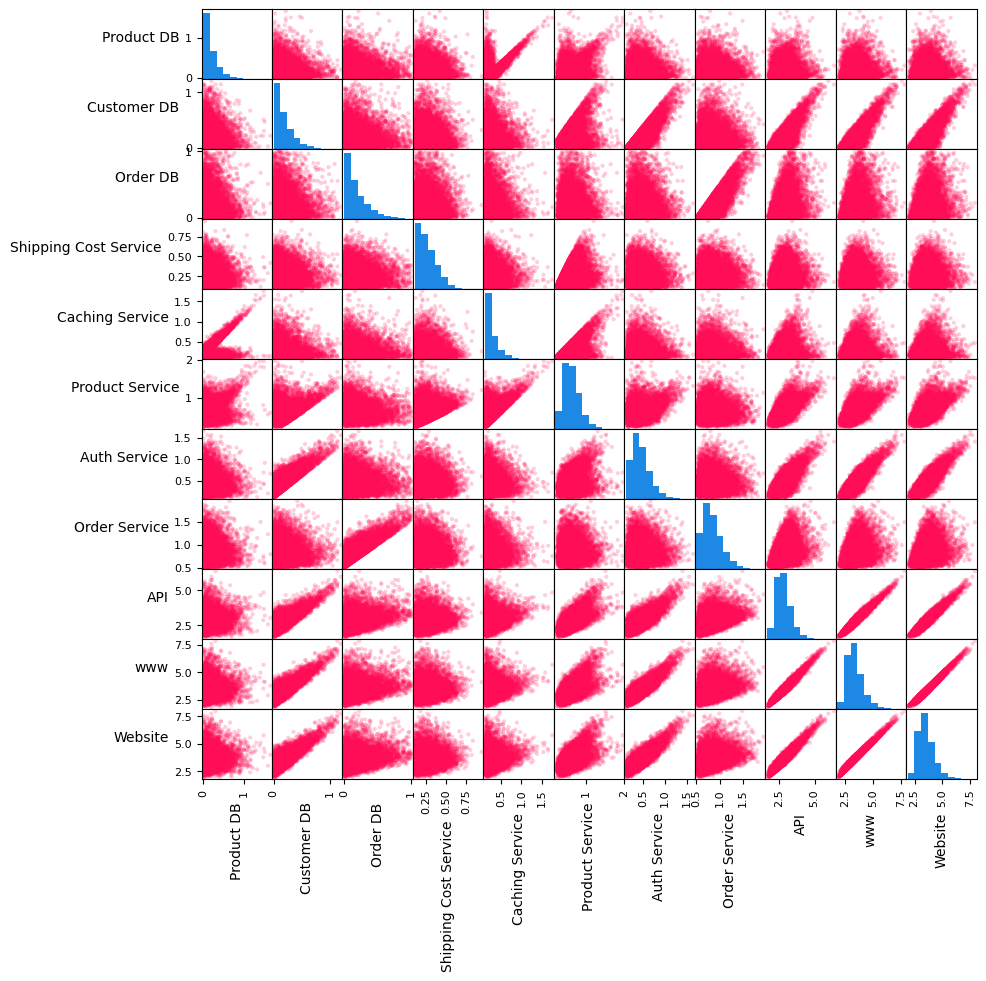

In [2]:
axes = pd.plotting.scatter_matrix(normal_data, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

In the matrix above, the plots on the diagonal line are histograms of variables, whereas those outside of the diagonal are scatter plots of pair of variables. The histograms of services without a dependency, namely `Customer DB`, `Product DB`, `Order DB` and `Shipping Cost Service`, have shapes similar to one half of a Gaussian distribution. The scatter plots of various pairs of variables (e.g., `API` and `www`, `www` and `Website`, `Order Service` and `Order DB`) show linear relations. We shall use this information shortly to assign generative causal models to nodes in the causal graph.

## Setting up the causal model

If we look at the `Website` node, it becomes apparent that the latency we experience there depends on the latencies of
all downstream nodes. In particular, if one of the downstream nodes takes a long time, `Website` will also take a
long time to show an update. Seeing this, the causal graph of the latencies can be built by inverting the arrows of the
service graph.

In [3]:
import networkx as nx
from dowhy import gcm
from dowhy.utils import plot, bar_plot
gcm.util.general.set_random_seed(0)

causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

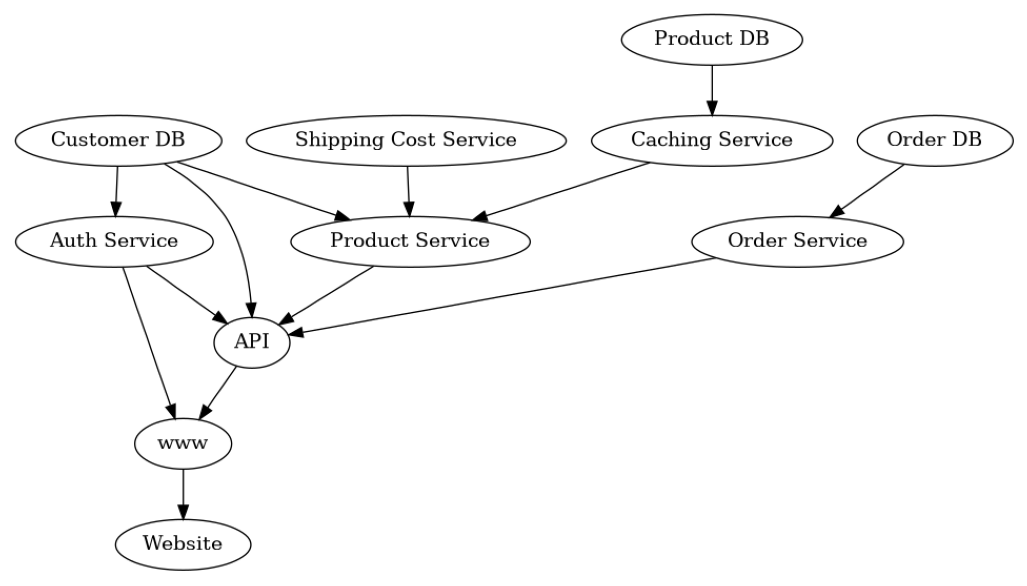

In [4]:
plot(causal_graph, figure_size=[13, 13])

> Here, we are interested in the causal relationships between latencies of services rather than the order of calling the services.

We will use the information from the pair-wise scatter plots and histograms to manually assign causal models. In particular, we assign half-Normal distributions to the root nodes (i.e., `Customer DB`, `Product DB`, `Order DB` and `Shipping Cost Service`). For non-root nodes, we assign linear additive noise models (which scatter plots of many parent-child pairs indicate) with empirical distribution of noise terms.

In [5]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

> Alternatively, we can also automate this **if** we don't have prior knowledge or are not familiar with the statistical implications:
```
gcm.auto.assign_causal_mechanisms(causal_model, normal_data)
```

Before we contiue with the first scenario, let's first evaluate our causal model:

Fitting causal models:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting causal mechanism of node www:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting causal mechanism of node Website:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting causal mechanism of node Auth Service:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting causal mechanism of node API:   0%|          | 0/11 [00:00<?, ?it/s]         

Fitting causal mechanism of node Customer DB:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting causal mechanism of node Product Service:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting causal mechanism of node Order Service:   0%|          | 0/11 [00:00<?, ?it/s]  

Fitting causal mechanism of node Shipping Cost Service:   0%|          | 0/11 [00:00<?, ?it/s]

Fitting causal mechanism of node Caching Service:   0%|          | 0/11 [00:00<?, ?it/s]      

Fitting causal mechanism of node Product DB:   0%|          | 0/11 [00:00<?, ?it/s]     

Fitting causal mechanism of node Order DB:   0%|          | 0/11 [00:00<?, ?it/s]  

Fitting causal mechanism of node Order DB: 100%|██████████| 11/11 [00:00<00:00, 395.17it/s]

Evaluating causal mechanisms...:   0%|          | 0/11 [00:00<?, ?it/s]

Evaluating causal mechanisms...:  73%|███████▎  | 8/11 [00:03<00:01,  2.66it/s]

Evaluating causal mechanisms...: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

Test permutations of given graph:   0%|          | 0/50 [00:00<?, ?it/s]

Test permutations of given graph:   2%|▏         | 1/50 [00:02<02:01,  2.48s/it]

Test permutations of given graph:   4%|▍         | 2/50 [00:04<01:44,  2.18s/it]

Test permutations of given graph:   6%|▌         | 3/50 [00:06<01:47,  2.28s/it]

Test permutations of given graph:   8%|▊         | 4/50 [00:09<01:46,  2.31s/it]

Test permutations of given graph:  10%|█         | 5/50 [00:11<01:40,  2.23s/it]

Test permutations of given graph:  12%|█▏        | 6/50 [00:13<01:37,  2.20s/it]

Test permutations of given graph:  14%|█▍        | 7/50 [00:14<01:21,  1.89s/it]

Test permutations of given graph:  16%|█▌        | 8/50 [00:16<01:22,  1.95s/it]

Test permutations of given graph:  18%|█▊        | 9/50 [00:18<01:20,  1.96s/it]

Test permutations of given graph:  20%|██        | 10/50 [00:20<01:20,  2.01s/it]

Test permutations of given graph:  22%|██▏       | 11/50 [00:22<01:14,  1.91s/it]

Test permutations of given graph:  24%|██▍       | 12/50 [00:24<01:13,  1.94s/it]

Test permutations of given graph:  26%|██▌       | 13/50 [00:26<01:06,  1.80s/it]

Test permutations of given graph:  28%|██▊       | 14/50 [00:27<01:02,  1.75s/it]

Test permutations of given graph:  30%|███       | 15/50 [00:29<01:05,  1.88s/it]

Test permutations of given graph:  32%|███▏      | 16/50 [00:31<01:02,  1.84s/it]

Test permutations of given graph:  34%|███▍      | 17/50 [00:33<00:56,  1.71s/it]

Test permutations of given graph:  36%|███▌      | 18/50 [00:34<00:56,  1.76s/it]

Test permutations of given graph:  38%|███▊      | 19/50 [00:36<00:52,  1.69s/it]

Test permutations of given graph:  40%|████      | 20/50 [00:37<00:46,  1.56s/it]

Test permutations of given graph:  42%|████▏     | 21/50 [00:39<00:44,  1.53s/it]

Test permutations of given graph:  44%|████▍     | 22/50 [00:40<00:41,  1.49s/it]

Test permutations of given graph:  46%|████▌     | 23/50 [00:41<00:38,  1.41s/it]

Test permutations of given graph:  48%|████▊     | 24/50 [00:42<00:33,  1.30s/it]

Test permutations of given graph:  50%|█████     | 25/50 [00:44<00:33,  1.36s/it]

Test permutations of given graph:  52%|█████▏    | 26/50 [00:45<00:34,  1.44s/it]

Test permutations of given graph:  54%|█████▍    | 27/50 [00:47<00:34,  1.49s/it]

Test permutations of given graph:  56%|█████▌    | 28/50 [00:48<00:32,  1.47s/it]

Test permutations of given graph:  58%|█████▊    | 29/50 [00:50<00:29,  1.38s/it]

Test permutations of given graph:  60%|██████    | 30/50 [00:51<00:29,  1.48s/it]

Test permutations of given graph:  62%|██████▏   | 31/50 [00:52<00:26,  1.38s/it]

Test permutations of given graph:  64%|██████▍   | 32/50 [00:53<00:22,  1.25s/it]

Test permutations of given graph:  66%|██████▌   | 33/50 [00:55<00:20,  1.22s/it]

Test permutations of given graph:  68%|██████▊   | 34/50 [00:56<00:19,  1.23s/it]

Test permutations of given graph:  70%|███████   | 35/50 [00:57<00:17,  1.18s/it]

Test permutations of given graph:  72%|███████▏  | 36/50 [00:58<00:17,  1.24s/it]

Test permutations of given graph:  74%|███████▍  | 37/50 [00:59<00:15,  1.17s/it]

Test permutations of given graph:  76%|███████▌  | 38/50 [01:00<00:14,  1.18s/it]

Test permutations of given graph:  78%|███████▊  | 39/50 [01:02<00:13,  1.18s/it]

Test permutations of given graph:  80%|████████  | 40/50 [01:03<00:11,  1.17s/it]

Test permutations of given graph:  82%|████████▏ | 41/50 [01:04<00:09,  1.07s/it]

Test permutations of given graph:  84%|████████▍ | 42/50 [01:05<00:08,  1.10s/it]

Test permutations of given graph:  86%|████████▌ | 43/50 [01:06<00:08,  1.19s/it]

Test permutations of given graph:  88%|████████▊ | 44/50 [01:07<00:06,  1.04s/it]

Test permutations of given graph:  90%|█████████ | 45/50 [01:08<00:04,  1.00it/s]

Test permutations of given graph:  92%|█████████▏| 46/50 [01:09<00:04,  1.07s/it]

Test permutations of given graph:  94%|█████████▍| 47/50 [01:10<00:03,  1.04s/it]

Test permutations of given graph:  96%|█████████▌| 48/50 [01:11<00:01,  1.05it/s]

Test permutations of given graph:  98%|█████████▊| 49/50 [01:12<00:00,  1.05it/s]

Test permutations of given graph: 100%|██████████| 50/50 [01:13<00:00,  1.06it/s]

Test permutations of given graph: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]

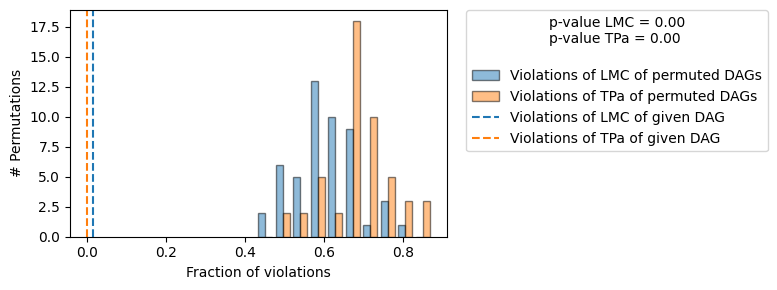

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [6]:
gcm.fit(causal_model, normal_data)
print(gcm.evaluate_causal_model(causal_model, normal_data))

This confirms the goodness of our causal model. However, we also see that for two nodes ('Product Service' and 'Caching Service'), the additive noise model assumption is violated. This also aligns with the data generation process, where these two nodes follow non-additive noise models. As we see in the following, most of the algorithms are still fairly robust against such violations or poor performance of the causal mechanism.

> For more detailed insights, set compare_mechanism_baselines to True. However, this will take significantly longer.

## Scenario 1: Observing a single outlier

Suppose we get an alert from our system where a customer experienced an unusually high latency when
an order is placed. Our task is now to investigate this issue and to find the root cause of this behaviour.

We first load the latency to the corresponding alert.

In [7]:
outlier_data = pd.read_csv("rca_microservice_architecture_anomaly.csv")
outlier_data

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.493145,0.180896,0.192593,0.197001,2.130865,2.48584,0.533847,1.132151,4.85583,5.522179,5.572588


We are interested in the increased latency of `Website` which the customer directly experienced.

In [8]:
outlier_data.iloc[0]['Website']-normal_data['Website'].mean()

For this customer, `Website` was roughly 2 seconds slower than for other customers on average. Why?

### Attributing an outlier latency at a target service to other services

To answer why `Website` was slower for this customer, we attribute the outlier latency at `Website` to upstream services in the causal graph. We refer the reader to [Janzing et al., 2019](https://arxiv.org/abs/1912.02724) for scientific details behind this API. We will calculate a 95% bootstrapped confidence interval of our attributions. In particular, we learn the causal models from a random subset of normal data and attribute the target outlier score using those models, repeating the process 10 times. This way, the confidence intervals we report account for (a) the uncertainty of our causal models as well as (b) the uncertainty in the attributions due to the variance in the samples drawn from those causal models.

In [9]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        causal_model,
                        normal_data,
                        target_node='Website',
                        anomaly_samples=outlier_data),
    num_bootstrap_resamples=10)

> By default, a quantile-based anomaly score is used that estimates the negative log-probability of a sample being
normal. This is, the higher the probabilty of an outlier, the larger the score. The library offers different kinds of outlier scoring functions, such as the <a href="https://en.wikipedia.org/wiki/Standard_score">z-score</a>, where the mean is the expected value based on the causal model.

Let us visualize the attributions along with their uncertainty in a bar plot.

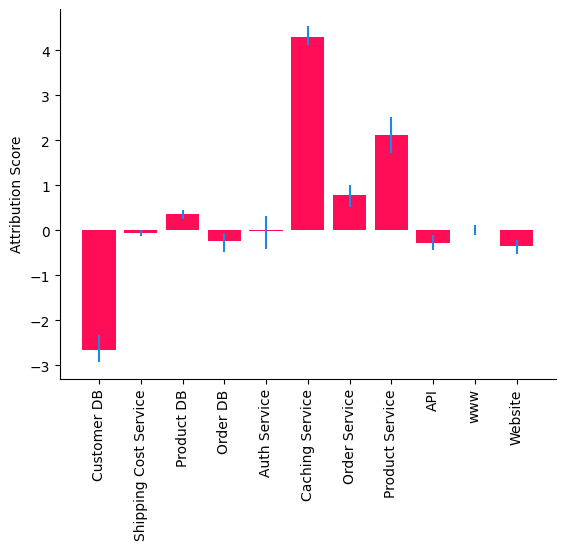

In [10]:
bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')

The attributions indicate that `Caching Service` is the main driver of high latency in `Website` which is expected as we perturb the causal mechanism of `Caching Service` to generate an outlier latency in `Website` (see Appendix below). Interestingly, `Customer DB` has a negative contribution, indicating that it was particularly fast, decreasing the outlier in the `Website`. Note that some of the attributions are also due to model misspecifications. For instance, the parent child-relationship between `Caching Service` and `Product DB` seems to indicate two mechanisms. This could be due to an unobserved binary variable (e.g., Cache hit/miss) that has a multiplicative effect on `Caching Service`. An additive noise cannot capture the multiplicative effect of this unobserved variable.

## Scenario 2: Observing permanent degradation of latencies

In the previous scenario, we attributed a *single* outlier latency in `Website` to services that are nodes in the causal graph, which is useful for anecdotal deep dives. Next, we consider a scenario where we observe a permanent degradation of latencies and we want to understand its drivers. In particular, we attribute the change in the average latency of `Website` to upstream nodes.

Suppose we get additional 1000 requests with higher latencies as follows.

In [11]:
outlier_data = pd.read_csv("rca_microservice_architecture_anomaly_1000.csv")
outlier_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.140874,0.270117,0.021619,0.159421,2.201327,2.453859,0.958687,0.572128,4.921074,5.891927,5.937950
1,0.160903,0.008235,0.182182,0.114568,2.105901,2.259432,0.325054,0.683030,4.009969,4.373290,4.418746
2,0.013300,0.127177,0.591904,0.112362,2.160395,2.278189,0.645109,1.097460,4.915487,5.578015,5.708616
3,1.317167,0.145850,0.094301,0.401206,3.505417,3.622197,0.502680,0.880008,5.652773,6.265665,6.356730
4,0.699519,0.425039,0.233269,0.572897,2.931482,3.062255,0.598265,0.885846,5.585744,6.266662,6.346390


We are interested in the increased latency of `Website` on average for 1000 requests which the customers directly experienced.

In [12]:
outlier_data['Website'].mean() - normal_data['Website'].mean()

The _Website_ is slower on average (by almost 2 seconds) than usual. Why?

### Attributing permanent degradation of latencies at a target service to other services

To answer why `Website` is slower for those 1000 requests compared to before, we attribute the change in the average latency of `Website` to services upstream in the causal graph. We refer the reader to [Budhathoki et al., 2021](https://assets.amazon.science/b6/c0/604565d24d049a1b83355921cc6c/why-did-the-distribution-change.pdf) for scientific details behind this API. As in the previous scenario, we will calculate a 95% bootstrapped confidence interval of our attributions and visualize them in a bar plot.

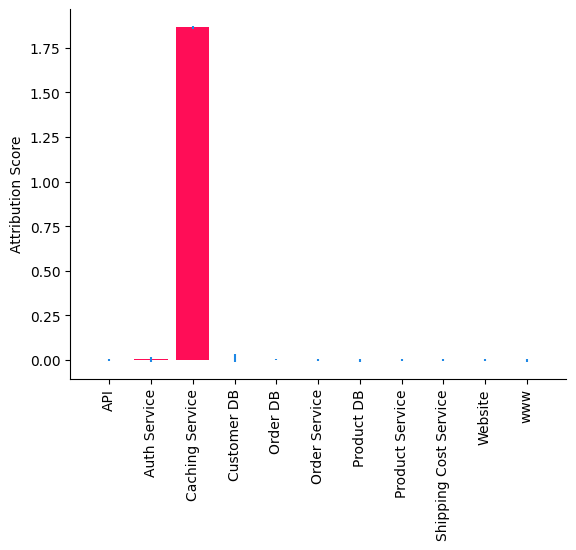

In [13]:
import numpy as np

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    lambda : gcm.distribution_change(causal_model,
                                     normal_data.sample(frac=0.6),
                                     outlier_data.sample(frac=0.6),
                                     'Website',
                                     difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x)),
    num_bootstrap_resamples = 10)

bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')

We observe that `Caching Service` is the root cause that slowed down `Website`. In particular, the method we used tells us that the change in the causal mechanism (i.e., the input-output behaviour) of `Caching Service` (e.g., Caching algorithm) slowed down `Website`. This is also expected as the outlier latencies were generated by changing the causal mechanism of `Caching Service` (see Appendix below).

## Scenario 3: Simulating the intervention of shifting resources

Next, let us imagine a scenario where permanent degradation has happened as in scenario 2 and we've successfully identified `Caching Service` as the root cause. Furthermore, we figured out that a recent deployment of the `Caching Service` contained a bug that is causing the overloaded hosts. A proper fix must be deployed, or the previous deployment must be rolled back. But, in the meantime, could we mitigate the situation by shifting over some resources from `Shipping Service` to `Caching Service`? And would that help? Before doing it in reality, let us simulate it first and see whether it improves the situation.

<img src="shifting-resources.png" width="600"/>

Let’s perform an intervention where we say we can reduce the average time of `Caching Service` by 1s. But at the same time we buy this speed-up by an average slow-down of 2s in `Shipping Cost Service`.

In [14]:
median_mean_latencies, uncertainty_mean_latencies = gcm.confidence_intervals(
    lambda : gcm.fit_and_compute(gcm.interventional_samples,
                                 causal_model,
                                 outlier_data,
                                 interventions = {
                                    "Caching Service": lambda x: x-1,
                                    "Shipping Cost Service": lambda x: x+2
                                 },
                                 observed_data=outlier_data)().mean().to_dict(),
    num_bootstrap_resamples=10)

Has the situation improved? Let's visualize the results.

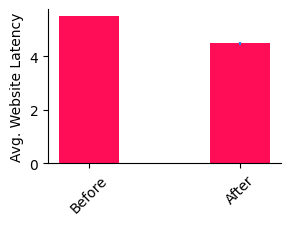

In [15]:
avg_website_latency_before = outlier_data.mean().to_dict()['Website']
bar_plot(dict(before=avg_website_latency_before, after=median_mean_latencies['Website']),
                  dict(before=np.array([avg_website_latency_before, avg_website_latency_before]), after=uncertainty_mean_latencies['Website']),
                  ylabel='Avg. Website Latency',
                  figure_size=(3, 2),
                  bar_width=0.4,
                  xticks=['Before', 'After'],
                  xticks_rotation=45)

Indeed, we do get an improvement by about 1s. We’re not back at normal operation, but we’ve mitigated part of the problem. From here, maybe we can wait until a proper fix is deployed.

## Appendix: Data generation process

The scenarios above work on synthetic data. The normal data was generated using the following functions:

In [16]:
from scipy.stats import truncexpon, halfnorm


def create_observed_latency_data(unobserved_intrinsic_latencies):
    observed_latencies = {}
    observed_latencies['Product DB'] = unobserved_intrinsic_latencies['Product DB']
    observed_latencies['Customer DB'] = unobserved_intrinsic_latencies['Customer DB']
    observed_latencies['Order DB'] = unobserved_intrinsic_latencies['Order DB']
    observed_latencies['Shipping Cost Service'] = unobserved_intrinsic_latencies['Shipping Cost Service']
    observed_latencies['Caching Service'] = np.random.choice([0, 1], size=(len(observed_latencies['Product DB']),),
                                                             p=[.5, .5]) * \
                                            observed_latencies['Product DB'] \
                                            + unobserved_intrinsic_latencies['Caching Service']
    observed_latencies['Product Service'] = np.maximum(np.maximum(observed_latencies['Shipping Cost Service'],
                                                                  observed_latencies['Caching Service']),
                                                       observed_latencies['Customer DB']) \
                                            + unobserved_intrinsic_latencies['Product Service']
    observed_latencies['Auth Service'] = observed_latencies['Customer DB'] \
                                         + unobserved_intrinsic_latencies['Auth Service']
    observed_latencies['Order Service'] = observed_latencies['Order DB'] \
                                          + unobserved_intrinsic_latencies['Order Service']
    observed_latencies['API'] = observed_latencies['Product Service'] \
                                + observed_latencies['Customer DB'] \
                                + observed_latencies['Auth Service'] \
                                + observed_latencies['Order Service'] \
                                + unobserved_intrinsic_latencies['API']
    observed_latencies['www'] = observed_latencies['API'] \
                                + observed_latencies['Auth Service'] \
                                + unobserved_intrinsic_latencies['www']
    observed_latencies['Website'] = observed_latencies['www'] \
                                    + unobserved_intrinsic_latencies['Website']

    return pd.DataFrame(observed_latencies)


def unobserved_intrinsic_latencies_normal(num_samples):
    return {
        'Website': truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'www': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'API': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Auth Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Product Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Order Service': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Shipping Cost Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Caching Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.1),
        'Order DB': truncexpon.rvs(size=num_samples, b=5, scale=0.2),
        'Customer DB': truncexpon.rvs(size=num_samples, b=6, scale=0.2),
        'Product DB': truncexpon.rvs(size=num_samples, b=10, scale=0.2)
    }


normal_data = create_observed_latency_data(unobserved_intrinsic_latencies_normal(10000))

This simulates the latency relationships under the assumption of having synchronized services and that there are no
hidden aspects that impact two nodes at the same time. Furthermore, we assume that the Caching Service has to call through to the Product DB only in 50% of the cases (i.e., we have a 50% cache miss rate). Also, we assume that the Product Service can make calls in parallel to its downstream services Shipping Cost Service, Caching Service, and Customer DB and join the threads when all three service have returned.

> We use <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncexpon.html">truncated exponential</a> and
<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.halfnorm.html">half-normal</a> distributions,
since their shapes are similar to distributions observed in real services.

The anomalous data is generated in the following way:

In [17]:
def unobserved_intrinsic_latencies_anomalous(num_samples):
    return {
        'Website': truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'www': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'API': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Auth Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Product Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Order Service': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Shipping Cost Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Caching Service': 2 + halfnorm.rvs(size=num_samples, loc=0.1, scale=0.1),
        'Order DB': truncexpon.rvs(size=num_samples, b=5, scale=0.2),
        'Customer DB': truncexpon.rvs(size=num_samples, b=6, scale=0.2),
        'Product DB': truncexpon.rvs(size=num_samples, b=10, scale=0.2)
    }

outlier_data = create_observed_latency_data(unobserved_intrinsic_latencies_anomalous(1000))

Here, we significantly increased the average time of the *Caching Service* by two seconds, which coincides with our
results from the RCA. Note that a high latency in *Caching Service* would lead to a constantly higher latency in upstream
services. In particular, customers experience a higher latency than usual.